In [200]:
import os
from pathlib import Path
from typing import List

import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sys

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [201]:
SEED = 42
IMAGE_SIZE = 128
BATCH_SIZE = 32
CLASSES = 6

In [202]:
def get_label(path: Path) -> int:
    return int(path.stem.split("_")[-1][0])


def _read_sample(path: str, label: int):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE, 3])
    return tf.cast(image, tf.float32) / 255, tf.one_hot(label, CLASSES)

def _get_dataset(
    paths: List[str],
    labels: List[int],
    shuffle: bool, 
    repeat: bool,
    cache: bool,
):
    auto = tf.data.experimental.AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(_read_sample, num_parallel_calls=auto)
    if shuffle:
        dataset = dataset.shuffle(1024, seed=SEED)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    if cache:
        dataset = dataset.cache()
    dataset = dataset.prefetch(auto)
    return dataset


def get_train_dataset(paths: List[str], labels: List[int]):
    return _get_dataset(
        paths=paths, labels=labels, shuffle=True, repeat=True, cache=False
    )


def get_val_dataset(paths: List[str], labels: List[int]):
    return _get_dataset(
        paths=paths, labels=labels, shuffle=False, repeat=False, cache=True
    )


def get_model():
    backbone = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3],
    )
    model = tf.keras.models.Sequential(
        [
            backbone,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(CLASSES, activation="softmax"),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [203]:
train_paths = list(Path("Datasets/training_images3").rglob("*.png"))
train_labels = [get_label(x) for x in train_paths]

val_paths = list(Path("Datasets/fingers/test").rglob("*.png"))
val_labels = [get_label(x) for x in val_paths]

print(f"Training on   {len(train_paths):,d} samples.")
print(f"Validating on {len(val_paths):,d} samples.")

Training on   12,006 samples.
Validating on 3,600 samples.


In [204]:
train_dataset = get_train_dataset(paths=[str(x) for x in train_paths], labels=train_labels)
val_dataset = get_val_dataset(paths=[str(x) for x in val_paths], labels=val_labels)



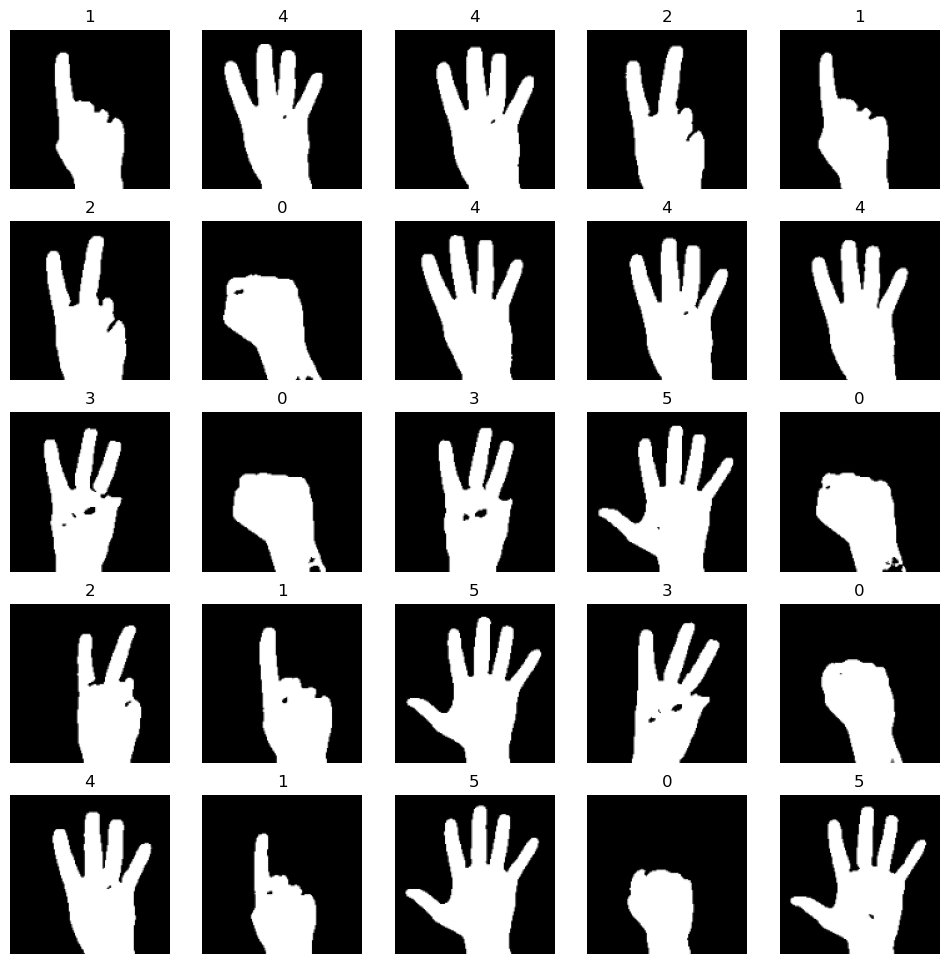

In [205]:
figure, axes = plt.subplots(5, 5, figsize = (12, 12))
axes = [y for x in axes for y in x]

for i, sample in enumerate(train_dataset.unbatch().take(25).as_numpy_iterator()):
    axes[i].imshow(sample[0])
    axes[i].set_title(tf.argmax(sample[1]).numpy())
    axes[i].axis('off')

In [206]:
model = get_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_11 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 4057257 (15.48 MB)
Trainable params: 4015234 (15.32 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [207]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    steps_per_epoch=len(train_paths) // BATCH_SIZE,
    validation_steps=len(val_paths) // BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "model.h5", 
            monitor="val_accuracy",
            mode="max", 
            save_best_only=True,
            save_weights_only=True,
            verbose=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            mode='max',
            patience=5,
            min_lr=1e-6,
            verbose=2,
        ),
    ],
    verbose=1,
).history

Epoch 1/200
375/375 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9829
Epoch 1: val_accuracy improved from -inf to 0.16629, saving model to model.h5
375/375 [==============================] - 186s 480ms/step - loss: 0.0791 - accuracy: 0.9829 - val_loss: 3.4375 - val_accuracy: 0.1663 - lr: 1.0000e-04
Epoch 2/200
375/375 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9998
Epoch 2: val_accuracy did not improve from 0.16629
375/375 [==============================] - 174s 464ms/step - loss: 0.0031 - accuracy: 0.9998 - val_loss: 2.8159 - val_accuracy: 0.1663 - lr: 1.0000e-04
Epoch 3/200
375/375 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998
Epoch 3: val_accuracy did not improve from 0.16629
375/375 [==============================] - 185s 492ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 2.9799 - val_accuracy: 0.1663 - lr: 1.0000e-04
Epoch 4/200
375/375 [==============================] - ETA: 0s - loss: 0.

Epoch 27/200
375/375 [==============================] - ETA: 0s - loss: 1.0470e-04 - accuracy: 0.9999
Epoch 27: val_accuracy did not improve from 0.32422
375/375 [==============================] - 184s 490ms/step - loss: 1.0470e-04 - accuracy: 0.9999 - val_loss: 3.6992 - val_accuracy: 0.2285 - lr: 1.0000e-05
Epoch 28/200
375/375 [==============================] - ETA: 0s - loss: 1.1517e-04 - accuracy: 0.9999
Epoch 28: val_accuracy improved from 0.32422 to 0.35017, saving model to model.h5
375/375 [==============================] - 184s 490ms/step - loss: 1.1517e-04 - accuracy: 0.9999 - val_loss: 2.1490 - val_accuracy: 0.3502 - lr: 1.0000e-05
Epoch 29/200
375/375 [==============================] - ETA: 0s - loss: 1.9700e-05 - accuracy: 1.0000
Epoch 29: val_accuracy did not improve from 0.35017
375/375 [==============================] - 186s 497ms/step - loss: 1.9700e-05 - accuracy: 1.0000 - val_loss: 3.5425 - val_accuracy: 0.2263 - lr: 1.0000e-05
Epoch 30/200
375/375 [==================

375/375 [==============================] - ETA: 0s - loss: 5.3077e-06 - accuracy: 1.0000
Epoch 53: val_accuracy did not improve from 0.35017
375/375 [==============================] - 189s 503ms/step - loss: 5.3077e-06 - accuracy: 1.0000 - val_loss: 2.9855 - val_accuracy: 0.2592 - lr: 1.0000e-06
Epoch 54/200
375/375 [==============================] - ETA: 0s - loss: 1.6302e-05 - accuracy: 1.0000
Epoch 54: val_accuracy did not improve from 0.35017
375/375 [==============================] - 187s 500ms/step - loss: 1.6302e-05 - accuracy: 1.0000 - val_loss: 2.7234 - val_accuracy: 0.2826 - lr: 1.0000e-06
Epoch 55/200
375/375 [==============================] - ETA: 0s - loss: 2.0684e-05 - accuracy: 1.0000
Epoch 55: val_accuracy did not improve from 0.35017
375/375 [==============================] - 189s 505ms/step - loss: 2.0684e-05 - accuracy: 1.0000 - val_loss: 2.8472 - val_accuracy: 0.2681 - lr: 1.0000e-06
Epoch 56/200
375/375 [==============================] - ETA: 0s - loss: 8.7823e-06 

375/375 [==============================] - 183s 488ms/step - loss: 5.5770e-06 - accuracy: 1.0000 - val_loss: 2.8925 - val_accuracy: 0.2720 - lr: 1.0000e-06
Epoch 80/200
375/375 [==============================] - ETA: 0s - loss: 4.4749e-06 - accuracy: 1.0000
Epoch 80: val_accuracy did not improve from 0.35017
375/375 [==============================] - 183s 488ms/step - loss: 4.4749e-06 - accuracy: 1.0000 - val_loss: 3.0701 - val_accuracy: 0.2586 - lr: 1.0000e-06
Epoch 81/200
375/375 [==============================] - ETA: 0s - loss: 3.7277e-05 - accuracy: 1.0000
Epoch 81: val_accuracy did not improve from 0.35017
375/375 [==============================] - 183s 488ms/step - loss: 3.7277e-05 - accuracy: 1.0000 - val_loss: 2.6483 - val_accuracy: 0.2932 - lr: 1.0000e-06
Epoch 82/200
375/375 [==============================] - ETA: 0s - loss: 1.0489e-05 - accuracy: 1.0000
Epoch 82: val_accuracy did not improve from 0.35017
375/375 [==============================] - 183s 488ms/step - loss: 1.0

KeyboardInterrupt: 

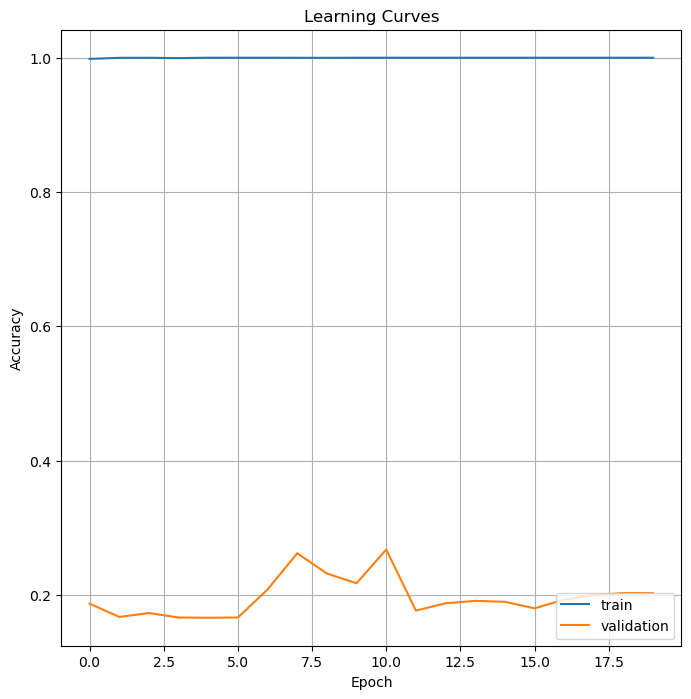

In [208]:
figure, axes = plt.subplots(1, 1, figsize = (8, 8))

epochs = list(range(len(history["loss"])))

axes.plot(epochs, history["accuracy"], label="train")
axes.plot(epochs, history["val_accuracy"], label="validation")
axes.set_title("Learning Curves")
axes.set_xlabel("Epoch")
axes.set_ylabel("Accuracy")
axes.legend(loc="lower right")
axes.grid()

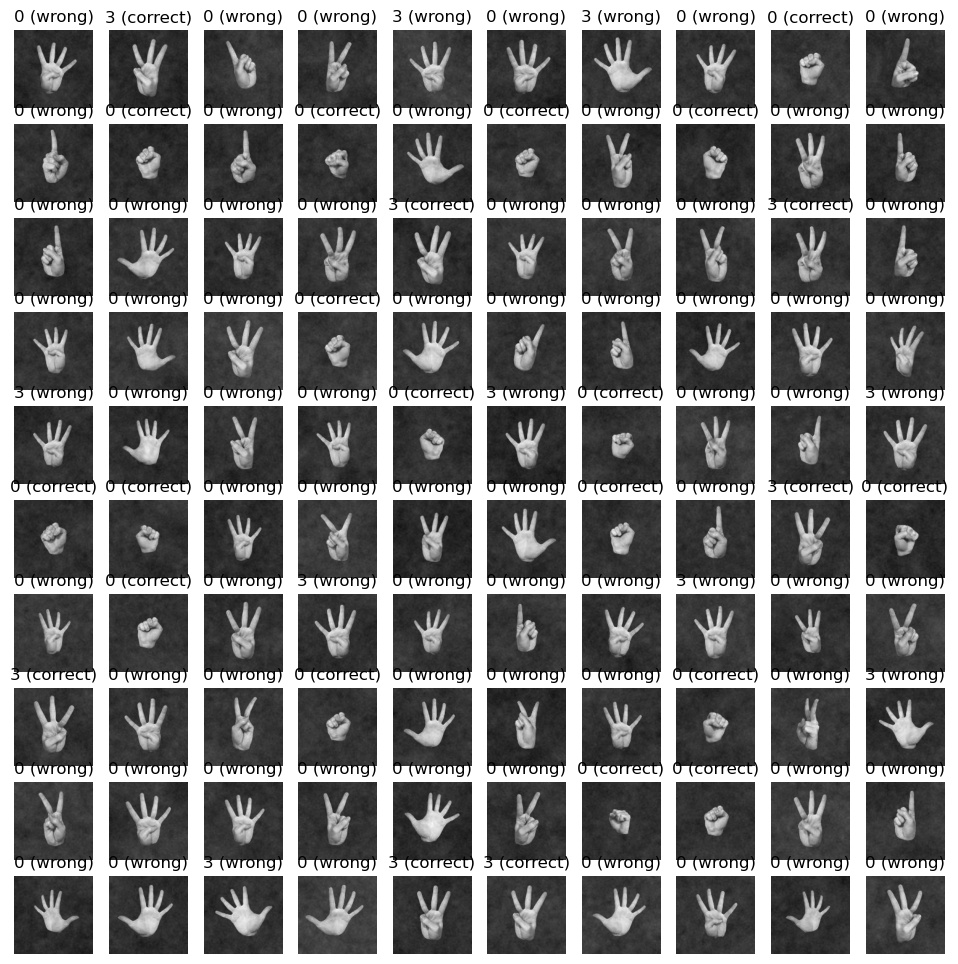

In [209]:
take_dataset = val_dataset.unbatch().take(100).batch(100)
predicts = model.predict(take_dataset, verbose=0)

figure, axes = plt.subplots(10, 10, figsize=(12, 12))
axes = [y for x in axes for y in x]

for i, (sample, predict) in enumerate(zip(take_dataset.unbatch().as_numpy_iterator(), predicts)):
    axes[i].imshow(sample[0])
    true_label = tf.argmax(sample[1]).numpy()
    predict_label = tf.argmax(predict)
    correct = true_label == predict_label
    axes[i].set_title(f"{predict_label} ({'correct' if correct else 'wrong'})")
    axes[i].axis("off")

In [210]:
val_paths = list(Path("Datasets/training_images3").rglob("*.png"))

val_labels = [get_label(x) for x in val_paths]
print(f"Validating on {len(val_paths):,d} samples.")

val_dataset = get_val_dataset(paths=[str(x) for x in val_paths], labels=val_labels)

Validating on 12,006 samples.


2024-02-25 02:05:47.068605: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-25 02:05:47.824708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


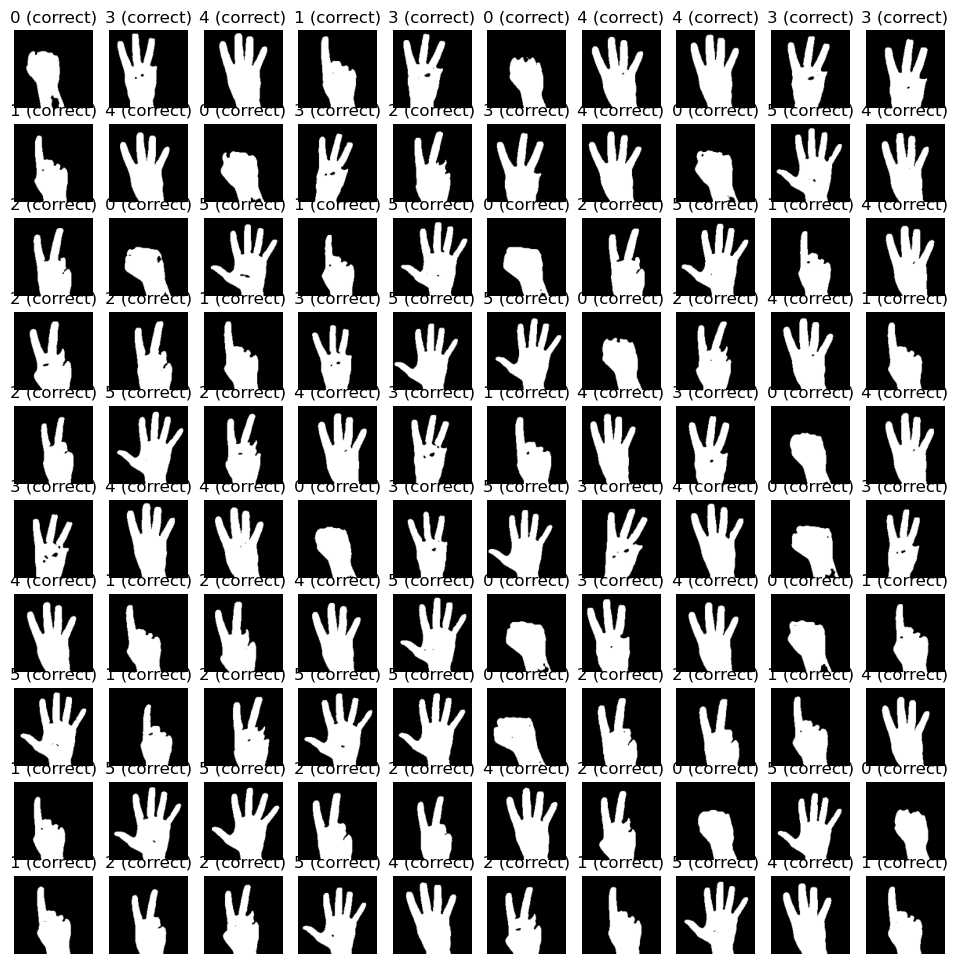

In [211]:
take_dataset = val_dataset.unbatch().take(100).batch(100)
predicts = model.predict(take_dataset, verbose=0)

figure, axes = plt.subplots(10, 10, figsize=(12, 12))
axes = [y for x in axes for y in x]

for i, (sample, predict) in enumerate(zip(take_dataset.unbatch().as_numpy_iterator(), predicts)):
    axes[i].imshow(sample[0])
    true_label = tf.argmax(sample[1]).numpy()
    predict_label = tf.argmax(predict)
    correct = true_label == predict_label
    axes[i].set_title(f"{predict_label} ({'correct' if correct else 'wrong'})")
    axes[i].axis("off")